# MIMIC-III Cohort

- Before running the notebook, you need to set your working directory as the folder containing this notebook and "hetero" folder, as in cell 1.

- Input your data in format of pickel file in cell 3. 

- Discount factor is set by "DISCOUNT = 0.6" in cell 16. 

In [1]:
import collections

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from hetero.algo import BetaOptimizer, MCPImpl
from hetero.config import DTYPE, AlgoConfig
from hetero.datagen import SARSDataWithLabels
from hetero.offline_rl import (
    ActorCriticLeaner,
    ActorCriticLearnerParams,
    SARSSamplePolicy,
)
from hetero.policies import UniformRandomPolicy
from hetero.tasks import beta_estimate_from, beta_estimate_from_e2e_learning
from hetero.utils import LabelPartitioner, lookup_inner

In [2]:
RAW_DATA = pd.read_pickle("hetero/data/rl_samples.pkl")

In [3]:
print(RAW_DATA.columns)

Index(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'mortality_90d', 'delay_end_of_record_and_discharge_or_death',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'median_dose_vaso', 'max_dose_vaso', 'input_total', 'input_4hourly',
       'output_total', 'output_4hourly', 'cumulated_balance', 'SOFA', 'SIRS',
       'act_iv', 'act_vaso', 'action', 'step', 'state', 'next_state',
       'trajectory', 'done', 'reward'],
      dtype='object')


In [4]:
SEED = 5555

sampler_rand = np.random.RandomState(SEED)
NUM_PATIENTS = 2000
re_admission = RAW_DATA[RAW_DATA.re_admission == 1].icustayid.unique()
SAMPLED_RE_ADMISSION_IDS = set(
    sampler_rand.choice(re_admission, size=NUM_PATIENTS // 2, replace=False)
)
first_time = RAW_DATA[RAW_DATA.re_admission == 0].icustayid.unique()
SAMPLED_FIRST_TIME_IDS = set(
    sampler_rand.choice(first_time, size=NUM_PATIENTS // 2, replace=False)
)
print(len(SAMPLED_RE_ADMISSION_IDS), len(SAMPLED_FIRST_TIME_IDS))
SAMPLED_DATA = RAW_DATA[
    RAW_DATA.icustayid.isin(SAMPLED_RE_ADMISSION_IDS | SAMPLED_FIRST_TIME_IDS)
]
SAMPLED_DATA.reset_index(drop=True, inplace=True)
SAMPLED_DATA.shape

1000 1000


(26355, 68)

In [5]:
# 47 columns of state variables
BINARY_COLS = [
    "gender",
    "mechvent",
    "max_dose_vaso",
    "re_admission",
    # New added features
    "died_in_hosp",
    "died_within_48h_of_out_time",
    "mortality_90d",
]
NORM_COLS = [
    "age",
    "Weight_kg",
    "GCS",
    "HR",
    "SysBP",
    "MeanBP",
    "DiaBP",
    "RR",
    "Temp_C",
    "FiO2_1",
    "Potassium",
    "Sodium",
    "Chloride",
    "Glucose",
    "Magnesium",
    "Calcium",
    "Hb",
    "WBC_count",
    "Platelets_count",
    "PTT",
    "PT",
    "Arterial_pH",
    "paO2",
    "paCO2",
    "Arterial_BE",
    "HCO3",
    "Arterial_lactate",
    "SOFA",
    "SIRS",
    "Shock_Index",
    "PaO2_FiO2",
    "cumulated_balance",
]
LOG_COLS = [
    "SpO2",
    "BUN",
    "Creatinine",
    "SGOT",
    "SGPT",
    "Total_bili",
    "INR",
    "input_total",
    "input_4hourly",
    "output_total",
    "output_4hourly",
]

print(len(BINARY_COLS), len(NORM_COLS), len(LOG_COLS))

7 32 11


In [6]:
binary_data = SAMPLED_DATA[BINARY_COLS]
print("BINARY_HAS_NULL=", binary_data.isnull().values.any())
norm_data = SAMPLED_DATA[NORM_COLS]
print("NORM_HAS_NULL=", norm_data.isnull().values.any())
log_data = SAMPLED_DATA[LOG_COLS]
print("LOG_HAS_NULL=", log_data.isnull().values.any())

from sklearn.preprocessing import normalize

FEATURE_DATA = pd.concat([binary_data, norm_data, log_data], axis=1)
FEATURE_COLS = FEATURE_DATA.columns
FEATURE_DATA = normalize(FEATURE_DATA)

BINARY_HAS_NULL= False
NORM_HAS_NULL= False
LOG_HAS_NULL= False


# MVPE Produces Bi-Model Residuals

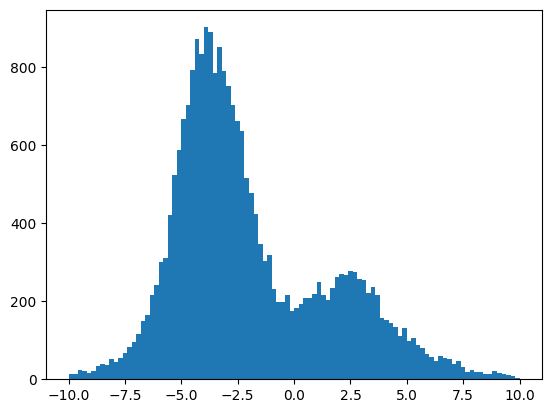

In [7]:
from sklearn.linear_model import LinearRegression

y = SAMPLED_DATA.reward
lr = LinearRegression(fit_intercept=False).fit(FEATURE_DATA, y)
y_pred = lr.predict(FEATURE_DATA)
residuals = y - y_pred
_ = plt.hist(residuals, range=[-10, 10], bins=100)

# Obtain top PC from 47 variables

In [8]:
pca = PCA(n_components=20)
pca.fit(FEATURE_DATA)

PCA(n_components=20)

In [9]:
NUM_SELECTED_COMPONENTS = 10
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_[:NUM_SELECTED_COMPONENTS]))

[5.23390220e-01 4.35339621e-01 3.28789412e-02 3.44723428e-03
 2.35378028e-03 1.07670939e-03 7.12455466e-04 4.29881517e-04
 2.39350800e-04 6.48920273e-05 2.23162530e-05 1.59482992e-05
 6.44868024e-06 4.53607543e-06 3.94733248e-06 3.43184797e-06
 2.52727755e-06 2.26207698e-06 1.50230180e-06 1.17158644e-06]
0.9999330866521235


In [10]:
PCA_PROJECTION_MATRIX = pca.components_[:NUM_SELECTED_COMPONENTS]
PROJECTED_FEATURES = FEATURE_DATA.dot(PCA_PROJECTION_MATRIX.T)
print(PROJECTED_FEATURES.shape)

(26355, 10)


# Discretize Actions into Three Levels

In [11]:
def _categrize_into_3(x):
    if x < 2:
        return 0
    if x == 2:
        return 1
    else:
        return 2


new_act_iv = SAMPLED_DATA.act_iv.apply(_categrize_into_3)
new_act_vaso = SAMPLED_DATA.act_vaso.apply(_categrize_into_3)
NUM_ACTIONS = 9
NEW_ACTIONS = new_act_iv * 3 + new_act_vaso
print(NEW_ACTIONS.describe())

count    26355.000000
mean         2.637526
std          2.851783
min          0.000000
25%          0.000000
50%          2.000000
75%          6.000000
max          8.000000
dtype: float64


In [12]:
icu2traj = collections.defaultdict(dict)
for i, (icu, step) in enumerate(zip(SAMPLED_DATA.icustayid, SAMPLED_DATA.step)):
    icu2traj[icu][step] = i

CURRENT_INDICES = []
NEXT_INDICES = []
for k, v in icu2traj.items():
    si = list(v.items())
    si.sort()
    sort_steps = [x[0] for x in si]
    assert sort_steps == list(range(1, len(si) + 1))
    for i in range(len(si) - 1):
        CURRENT_INDICES.append(si[i][1])
        NEXT_INDICES.append(si[i + 1][1])

In [13]:
current_features = PROJECTED_FEATURES[CURRENT_INDICES].astype(DTYPE)
actions = NEW_ACTIONS[CURRENT_INDICES].to_numpy()
actions = lookup_inner(np.eye(NUM_ACTIONS, dtype=DTYPE), actions)
rewards = np.clip(
    SAMPLED_DATA.reward[CURRENT_INDICES].to_numpy().astype(DTYPE), -10, 10
)
next_features = PROJECTED_FEATURES[NEXT_INDICES].astype(DTYPE)

print(current_features.shape, actions.shape, rewards.shape, next_features.shape)

#_ = plt.hist(rewards, bins=100)

(24355, 10) (24355, 9) (24355,) (24355, 10)


# Change Data to SARS Format

In [14]:
labels = list(
    zip(
        SAMPLED_DATA.re_admission[CURRENT_INDICES].to_numpy().astype(np.int32),
        SAMPLED_DATA.icustayid[CURRENT_INDICES].to_numpy().astype(np.int32),
    )
)
partitioner = LabelPartitioner(labels)
time_step_indices = SAMPLED_DATA.step[CURRENT_INDICES] - 1

SARS_DATA = SARSDataWithLabels(
    current_features,
    actions,
    rewards,
    next_features,
    labels,
    partitioner,
    time_step_indices,
)

In [15]:
DISCOUNT = 0.6

group_beta = beta_estimate_from(
    SARS_DATA.replace_labels([x[0] for x in SARS_DATA.labels]),
    UniformRandomPolicy(NUM_ACTIONS, np.random.RandomState(SEED)),
    DISCOUNT,
)

new_labels.length=24355 matches number of records


In [16]:
init_beta_list = [
    group_beta.betas[x[0]] for x in SARS_DATA.partitioner.index_to_label_mapping()
]
init_beta = np.stack(init_beta_list, axis=0)
print(init_beta[:2, :5])
print(init_beta[600:602, :5])
print(init_beta.shape)

[[ -1.142562    -0.23313394   1.6791248   -1.3171136  -25.678654  ]
 [ -1.142562    -0.23313394   1.6791248   -1.3171136  -25.678654  ]]
[[ -1.142562    -0.23313394   1.6791248   -1.3171136  -25.678654  ]
 [ -1.142562    -0.23313394   1.6791248   -1.3171136  -25.678654  ]]
(1973, 90)


In [35]:
base_config = dict(
    max_num_iters=3,
    should_remove_outlier=True,
    outlier_lower_perc=2,
    outlier_upper_perc=98,
    gam=4.0,
    lam=2.0,
    rho=10.0,
    nu_coeff=1e-19,
    delta_coeff=1e-19,
    discount=DISCOUNT,
)

algo_config = AlgoConfig(**base_config)
impl = MCPImpl(SARS_DATA.N(), algo_config)
pi_eval = UniformRandomPolicy(NUM_ACTIONS, np.random.RandomState(SEED))
beta_opt = BetaOptimizer(SARS_DATA, algo_config, pi_eval, impl, init_beta)
beta_optimized = beta_opt.compute()

beta_solver, min eigen of left matrix = (0.077899225+0j)
MCPImpl: num_above=1945160, num_below=218
beta_solver, min eigen of left matrix = (0.077899225+0j)
MCPImpl: num_above=1945188, num_below=190
beta_solver, min eigen of left matrix = (0.077899225+0j)
MCPImpl: num_above=1945178, num_below=200


In [18]:
# Save your results 

#import pickle

#with open(f'results/mimic_2k_beta_hat_{DISCOUNT}.pkl', 'wb') as file:
#    pickle.dump(beta_optimized, file)

In [43]:
# Load runned results

import pickle

with open(f'results/mimic_2k_beta_hat_{DISCOUNT}.pkl', 'rb') as file:
    beta_optimized = pickle.load(file)

# ACPE and Plot Residuals

new_labels.length=24355 matches number of records


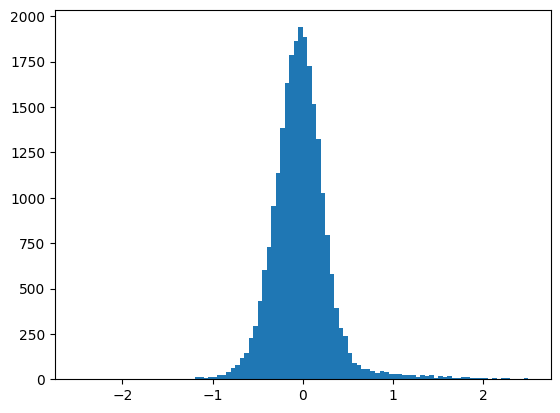

In [44]:
from hetero.tasks import beta_estimate_from_new_labels

ret = beta_estimate_from_new_labels(
    SARS_DATA, [0] * SARS_DATA.NT(), pi_eval, algo_config.discount
)[0]

_ = plt.hist(ret.all_residuals, bins=100, range=[-2.5, 2.5])

# Clustering based on ACPE

In [45]:
beta_optimized_pca = PCA(n_components=10)
beta_optimized_pca.fit(beta_optimized)

beta_proj = beta_optimized_pca.components_[:2]
beta_optimized_proj = beta_optimized.dot(beta_proj.T)
print(beta_optimized_proj.shape)
#plt.scatter(beta_optimized_proj[:, 0], beta_optimized_proj[:, 1])

(1973, 2)


In [46]:
from sklearn.cluster import KMeans

common_params = {
    "n_init": "auto",
    "random_state": 6789
}
cluster_pred = KMeans(n_clusters=2, **common_params).fit_predict(beta_optimized_proj)

In [47]:
cluster_pred.shape, np.sum(cluster_pred)

((1973,), 921)

In [48]:
beta_pca2_g0 = beta_optimized_proj[cluster_pred==0, :]
beta_pca2_g1 = beta_optimized_proj[cluster_pred==1, :]
mean0 = np.mean(beta_pca2_g0, axis=0)
mean1 = np.mean(beta_pca2_g1, axis=0)

beta_pca2_mean = np.vstack([mean1,mean0])

In [49]:
mean0, mean1

(array([ -29.45875301, -898.38374904]), array([-604.80646044, -892.85293455]))

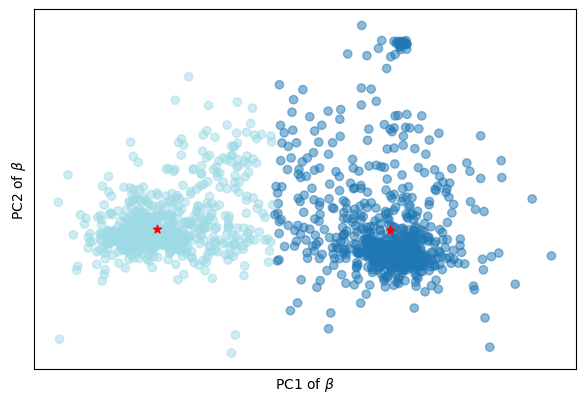

In [67]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#plt.figure(figsize=(8,3))
fig, ax = plt.subplots(figsize=(7,4.68))
plt.set_cmap('tab20')
plt.scatter(beta_optimized_proj[:, 0], beta_optimized_proj[:, 1], 
            c=cluster_pred, alpha=0.5)

plt.scatter(beta_pca2_mean[:, 0], beta_pca2_mean[:, 1], 
            marker='*', color="r")

ax.set_xticks([])
ax.set_yticks([])

plt.xlabel("PC1 of $\\beta$")
plt.ylabel("PC2 of $\\beta$")

plt.savefig(f'results/mimic_2k_betas_{DISCOUNT}.pdf', bbox_inches='tight')

In [27]:
mpl.colormaps['Pastel1']
mpl.cm.get_cmap('Pastel1')(0)

/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_1835/1212173918.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl.cm.get_cmap('Pastel1')(0)


(0.984313725490196, 0.7058823529411765, 0.6823529411764706, 1.0)

/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_1835/200696969.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.hist(beta_optimized_proj[:, 0], bins=100, color=mpl.cm.get_cmap('Pastel1')(1))


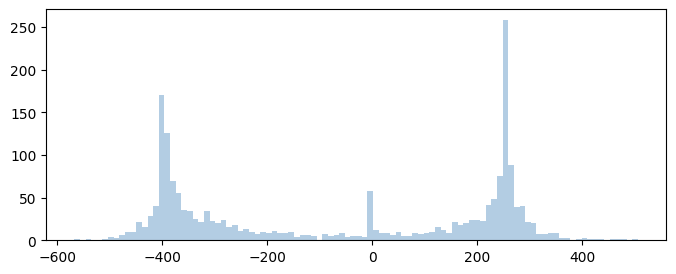

In [28]:
plt.figure(figsize=(8,3))
plt.hist(beta_optimized_proj[:, 0], bins=100, color=mpl.cm.get_cmap('Pastel1')(1))
plt.savefig(f'results/mimic_2k_betas_first_evals_{DISCOUNT}.pdf', bbox_inches='tight')

/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_1835/3014022541.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axes[1].hist(beta_pca2_g0[:,0], bins=100, density=True, color=mpl.cm.get_cmap('tab20')(0))
/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_1835/3014022541.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axes[1].hist(beta_pca2_g1[:,0], bins=100, density=True, color=mpl.cm.get_cmap('tab20')(19)) # left circle is group 1


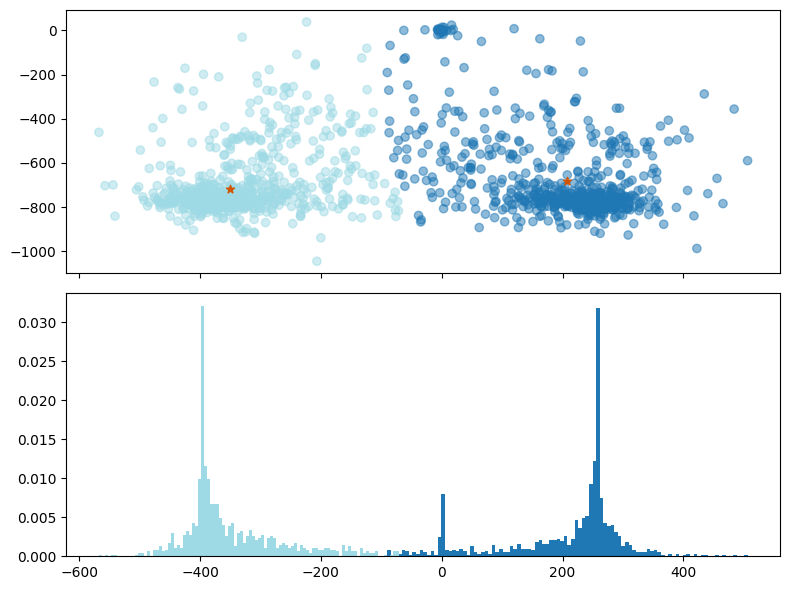

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, axes = plt.subplots(2,figsize=(8,6),sharex=True,layout='tight')

plt.set_cmap('tab20')
axes[0].scatter(beta_optimized_proj[:, 0], beta_optimized_proj[:, 1], 
            c=cluster_pred, alpha=0.5)
axes[0].scatter(beta_pca2_mean[:, 0], beta_pca2_mean[:, 1], 
            marker='*', color='#D35400')

axes[1].hist(beta_pca2_g0[:,0], bins=100, density=True, color=mpl.cm.get_cmap('tab20')(0))

axes[1].hist(beta_pca2_g1[:,0], bins=100, density=True, color=mpl.cm.get_cmap('tab20')(19)) # left circle is group 1

fig.savefig(f'results/mimic_2k_betas_all_{DISCOUNT}.pdf', bbox_inches='tight')

In [30]:
#import seaborn as sns

first_beta_component = beta_optimized_pca.components_[0, :].reshape([9, 10])


def heatmap_for_beta(beta, save_file=None):
    x_lables = FEATURE_COLS
    y_labels = [f"iv={al},vaso={vl}" for al in "LMH" for vl in "LMH"]
    heatmap = beta.dot(PCA_PROJECTION_MATRIX)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(np.abs(heatmap), cmap="Blues")#cmap="YlGn")
    ax.set_xticks(np.arange(len(x_lables)), labels=x_lables, rotation=90)
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)
    
    if save_file is not None:
        fig.savefig(save_file, bbox_inches='tight')


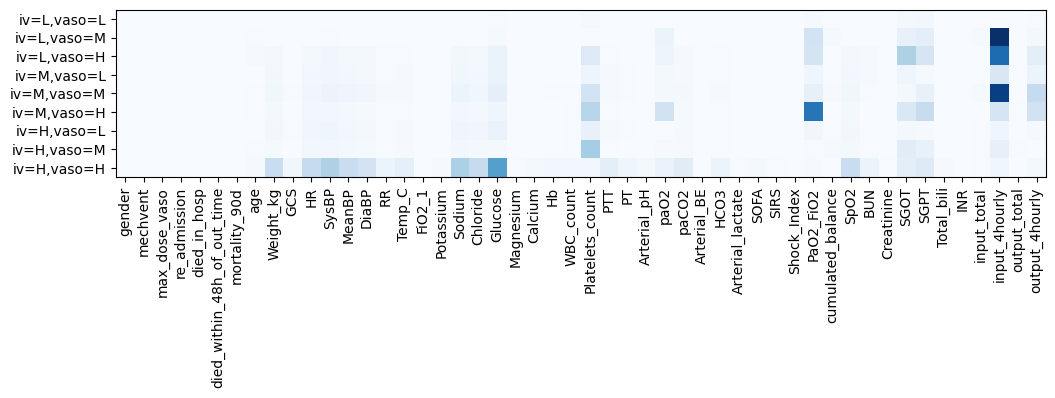

In [31]:
heatmap_for_beta(first_beta_component, f'results/heatmap_act_var_random_pi_{DISCOUNT}.pdf')

# ACPI

In [32]:
import collections
import importlib

import hetero.algo as algo_mod
import hetero.config as config_mod
import hetero.offline_rl as offline_rl_mod
import hetero.utils as utils_mod

algo_mod = importlib.reload(algo_mod)
config_mod = importlib.reload(config_mod)
offline_rl_mod = importlib.reload(offline_rl_mod)
utils_mod = importlib.reload(utils_mod)

learned_labels = algo_mod.group(
    beta_optimized, config_mod.GroupingConfig(num_clusters=2)
)

collections.Counter(learned_labels)

rl_split_pols = offline_rl_mod.split_sars_data_for_rl(SARS_DATA, learned_labels)
RL_PARAMS = offline_rl_mod.ActorCriticLearnerParams(
    discount=DISCOUNT, lr=2e-2, decay=1e-4, grad_norm_clip=1000
)

kmeans center = [[ 1.78231044e-01  1.15073169e+00  3.22062850e-01  1.67565705e+00
   3.25274609e+00  4.85262864e+00  1.22440787e+01 -4.39907929e-01
  -8.44113426e-01 -7.61168129e+00  1.76164837e+00  8.52268952e+00
  -5.47578644e+00 -3.59752179e+01  1.47919354e+02 -4.37158510e+01
   8.65096423e+01 -2.91226465e+01 -3.19292192e+02  2.26323471e+01
   1.34155971e+01  1.29774533e+00 -6.51451407e-01  1.08181373e+02
   1.13330440e+02 -2.55944386e+01  6.11032491e+01  3.32547517e+02
   7.10161568e+01 -5.93524676e+00 -2.14453679e+00  1.09254845e+00
   2.26608348e-01 -6.77931549e+00  3.66617940e+01  2.32814910e+00
   2.19176438e+01 -5.72333925e+01  1.35380933e+01  6.70341045e+00
  -2.23391981e+00  2.35312443e+00 -3.98569895e+00  4.01629987e+01
   2.64082615e+02  3.98612661e+01  4.96509248e+01  6.23424584e+01
   3.18840877e+01  1.74275576e+01  1.07792831e+00  2.83238454e+00
   2.81432899e+00  2.40381784e+02 -2.43192095e+01 -8.86001064e+00
   6.93760434e+01  3.47338700e+02  1.42983393e+00 -5.4399088

In [33]:
cluster = 0
rl_pol = rl_split_pols[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_0 = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)

print("Before RL:", acl_0.weights())
print("Before RL:", acl_0.kernel())

#heatmap_for_beta(acl_0.kernel())

Perfoming RL for cluster=0 with 11380 records
Before RL: [[-8.61499459e-04  1.28177751e-03 -7.34843733e-03  7.07507133e-03
  -1.99332065e-03  9.31813475e-03  7.78418675e-04 -7.72880274e-04
  -5.33865823e-05 -1.35111413e-03]
 [-4.17831168e-03  6.17733039e-03 -5.74558275e-03 -7.49931997e-03
  -4.17017331e-03  3.17487423e-03 -8.94761458e-03  3.18311946e-03
   4.06981306e-03  2.47071078e-03]
 [-1.50023599e-03  9.41913575e-03  9.45017952e-03 -8.95755645e-03
  -9.32356808e-03 -3.44965723e-03  4.48350515e-03  3.10564321e-03
  -2.18200521e-03 -6.92134164e-03]
 [ 7.42145022e-03  2.78058182e-03  8.15275963e-03 -4.49675275e-03
  -1.70300412e-03  8.99988785e-03 -6.53111655e-03 -9.01421811e-03
   5.53655671e-03 -3.07160080e-04]
 [ 3.98945715e-03 -5.67284413e-03  8.24320223e-03  1.25035679e-03
  -7.28423847e-03  1.01441125e-04 -9.94840357e-03  7.32897315e-03
  -3.89774214e-03  2.57832836e-03]
 [-4.45556594e-04  7.80370319e-04  8.31425376e-03 -4.05392237e-03
  -8.91042000e-04 -3.40167386e-03  5.43943

In [34]:
acl_0.learn()
print("After RL:", acl_0.weights())
print("After RL:", acl_0.kernel())

print(f"MEAN_Y_FINAL={acl_0.eval()} and #SAMPLES={acl_0.sample_pi.num_samples}")

  * At actor-learn step 0, g_norm=398.476, y=-16166.790
  * At actor-learn step 1, g_norm=405.452, y=-16134.577
  * At actor-learn step 1, stopped at y=-16134.577, prev_y=-16166.790, relative_error=0.002
* At alter step 0, diff_norm=0.281, cur_norm=0.053, relative_error=4.484
  * At actor-learn step 0, g_norm=423.955, y=-16078.844
  * At actor-learn step 1, g_norm=430.752, y=-16044.757
  * At actor-learn step 1, stopped at y=-16044.757, prev_y=-16078.844, relative_error=0.002
* At alter step 1, diff_norm=0.286, cur_norm=0.280, relative_error=0.984
  * At actor-learn step 0, g_norm=451.984, y=-15979.838
  * At actor-learn step 1, g_norm=458.416, y=-15943.799
  * At actor-learn step 1, stopped at y=-15943.799, prev_y=-15979.838, relative_error=0.002
* At alter step 2, diff_norm=0.286, cur_norm=0.563, relative_error=0.500
  * At actor-learn step 0, g_norm=482.547, y=-15874.388
  * At actor-learn step 1, g_norm=488.973, y=-15836.232
  * At actor-learn step 1, stopped at y=-15836.232, prev_

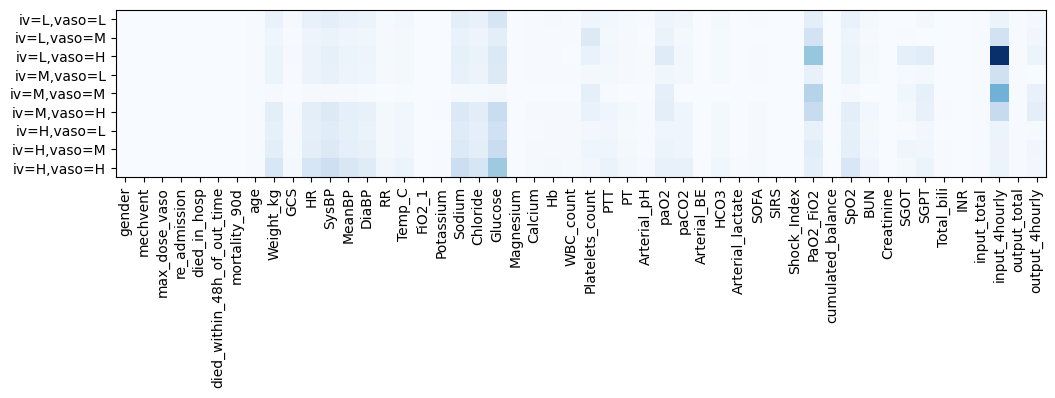

In [35]:
heatmap_for_beta(acl_0.kernel())

In [36]:
cluster = 1
rl_pol = rl_split_pols[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_1 = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)

print("Before RL:", acl_1.weights())
print("Before RL:", acl_1.kernel())

Perfoming RL for cluster=1 with 12975 records
Before RL: [[-8.61499459e-04  1.28177751e-03 -7.34843733e-03  7.07507133e-03
  -1.99332065e-03  9.31813475e-03  7.78418675e-04 -7.72880274e-04
  -5.33865823e-05 -1.35111413e-03]
 [-4.17831168e-03  6.17733039e-03 -5.74558275e-03 -7.49931997e-03
  -4.17017331e-03  3.17487423e-03 -8.94761458e-03  3.18311946e-03
   4.06981306e-03  2.47071078e-03]
 [-1.50023599e-03  9.41913575e-03  9.45017952e-03 -8.95755645e-03
  -9.32356808e-03 -3.44965723e-03  4.48350515e-03  3.10564321e-03
  -2.18200521e-03 -6.92134164e-03]
 [ 7.42145022e-03  2.78058182e-03  8.15275963e-03 -4.49675275e-03
  -1.70300412e-03  8.99988785e-03 -6.53111655e-03 -9.01421811e-03
   5.53655671e-03 -3.07160080e-04]
 [ 3.98945715e-03 -5.67284413e-03  8.24320223e-03  1.25035679e-03
  -7.28423847e-03  1.01441125e-04 -9.94840357e-03  7.32897315e-03
  -3.89774214e-03  2.57832836e-03]
 [-4.45556594e-04  7.80370319e-04  8.31425376e-03 -4.05392237e-03
  -8.91042000e-04 -3.40167386e-03  5.43943

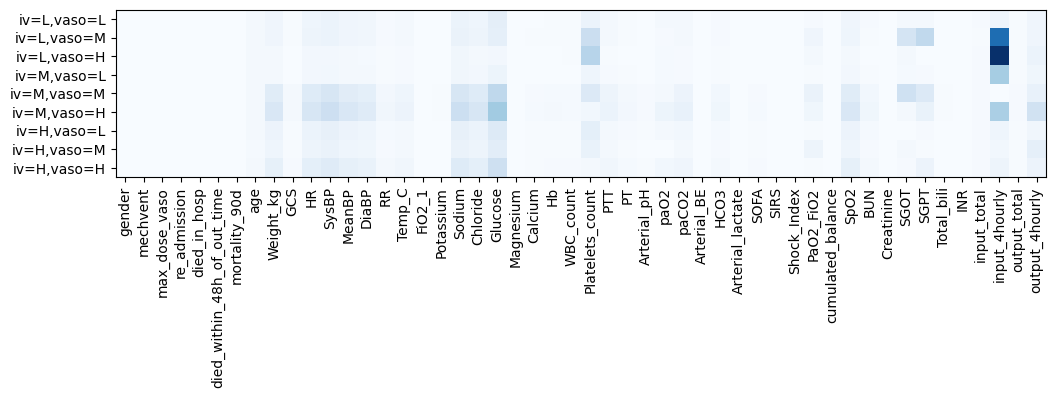

In [37]:
heatmap_for_beta(acl_1.kernel())

In [38]:
acl_1.learn()
print("After RL:", acl_1.weights())
print("After RL:", acl_1.kernel())
print(f"MEAN_Y_FINAL={acl_1.eval()} and #SAMPLES={acl_1.sample_pi.num_samples}")

  * At actor-learn step 0, g_norm=1275.828(CLIP@1000), y=-15947.970
  * At actor-learn step 1, g_norm=1304.872(CLIP@1000), y=-15870.561
  * At actor-learn step 1, stopped at y=-15870.561, prev_y=-15947.970, relative_error=0.005
* At alter step 0, diff_norm=0.236, cur_norm=0.053, relative_error=3.768
  * At actor-learn step 0, g_norm=1390.298(CLIP@1000), y=-15245.816
  * At actor-learn step 1, g_norm=1417.978(CLIP@1000), y=-15168.434
  * At actor-learn step 1, stopped at y=-15168.434, prev_y=-15245.816, relative_error=0.005
* At alter step 1, diff_norm=0.218, cur_norm=0.240, relative_error=0.872
  * At actor-learn step 0, g_norm=1507.680(CLIP@1000), y=-14515.518
  * At actor-learn step 1, g_norm=1533.980(CLIP@1000), y=-14438.201
  * At actor-learn step 1, stopped at y=-14438.201, prev_y=-14515.518, relative_error=0.005
* At alter step 2, diff_norm=0.202, cur_norm=0.455, relative_error=0.434
  * At actor-learn step 0, g_norm=1630.756(CLIP@1000), y=-13722.092
  * At actor-learn step 1, g_

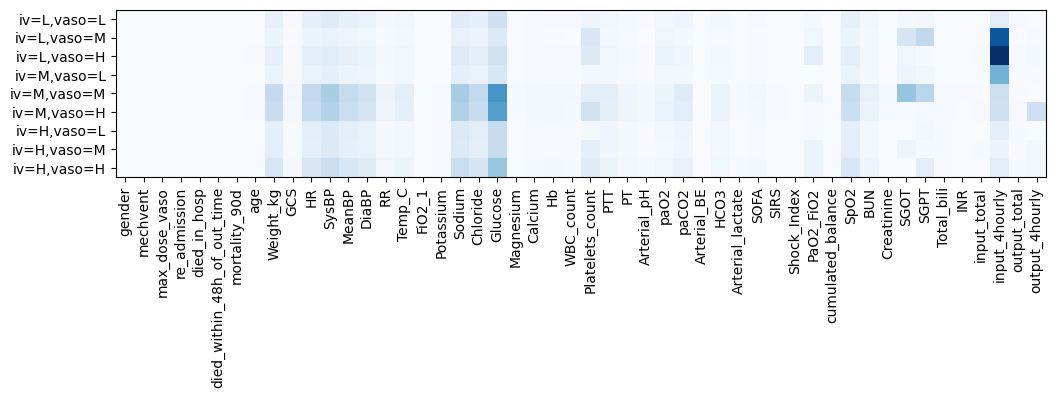

In [39]:
heatmap_for_beta(acl_1.kernel())

## Plot heatmaps of two groups together

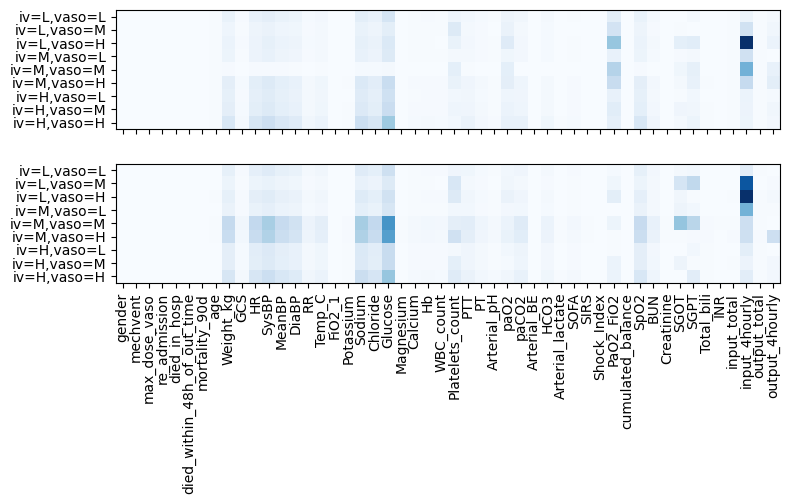

In [40]:
x_lables = FEATURE_COLS
y_labels = [f"iv={al},vaso={vl}" for al in "LMH" for vl in "LMH"]

heatmap_g0 = acl_0.kernel().dot(PCA_PROJECTION_MATRIX)
heatmap_g1 = acl_1.kernel().dot(PCA_PROJECTION_MATRIX)

fig, axes = plt.subplots(2,figsize=(8,6),sharex=True,layout='tight')

axes[0].imshow(np.abs(heatmap_g0), cmap="Blues")
axes[1].imshow(np.abs(heatmap_g1), cmap="Blues")

axes[0].set_xticks(np.arange(len(x_lables)), labels=x_lables, rotation=90)
axes[0].set_yticks(np.arange(len(y_labels)), labels=y_labels)
axes[1].set_xticks(np.arange(len(x_lables)), labels=x_lables, rotation=90)
axes[1].set_yticks(np.arange(len(y_labels)), labels=y_labels)

fig.savefig(f'results/betas_act_var_heatmap_opt_g01_{DISCOUNT}.pdf', bbox_inches='tight')

# MVPI

In [41]:
rl_pols = offline_rl_mod.split_sars_data_for_rl(SARS_DATA, [0] * SARS_DATA.NT())
RL_PARAMS = offline_rl_mod.ActorCriticLearnerParams(
    discount=DISCOUNT, lr=1e-2, decay=1e-4, grad_norm_clip=1000
)

In [42]:
cluster = 0
rl_pol = rl_pols[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_comb = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)

print("Before RL:", acl_comb.weights())
print("Before RL:", acl_comb.kernel())


Perfoming RL for cluster=0 with 24355 records
Before RL: [[-8.61499459e-04  1.28177751e-03 -7.34843733e-03  7.07507133e-03
  -1.99332065e-03  9.31813475e-03  7.78418675e-04 -7.72880274e-04
  -5.33865823e-05 -1.35111413e-03]
 [-4.17831168e-03  6.17733039e-03 -5.74558275e-03 -7.49931997e-03
  -4.17017331e-03  3.17487423e-03 -8.94761458e-03  3.18311946e-03
   4.06981306e-03  2.47071078e-03]
 [-1.50023599e-03  9.41913575e-03  9.45017952e-03 -8.95755645e-03
  -9.32356808e-03 -3.44965723e-03  4.48350515e-03  3.10564321e-03
  -2.18200521e-03 -6.92134164e-03]
 [ 7.42145022e-03  2.78058182e-03  8.15275963e-03 -4.49675275e-03
  -1.70300412e-03  8.99988785e-03 -6.53111655e-03 -9.01421811e-03
   5.53655671e-03 -3.07160080e-04]
 [ 3.98945715e-03 -5.67284413e-03  8.24320223e-03  1.25035679e-03
  -7.28423847e-03  1.01441125e-04 -9.94840357e-03  7.32897315e-03
  -3.89774214e-03  2.57832836e-03]
 [-4.45556594e-04  7.80370319e-04  8.31425376e-03 -4.05392237e-03
  -8.91042000e-04 -3.40167386e-03  5.43943

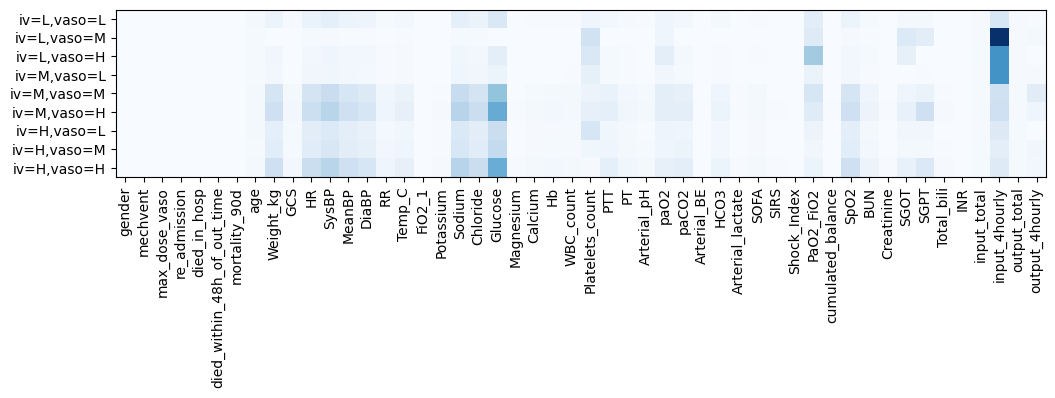

In [49]:
# Heat map for MVPE
heatmap_for_beta(acl_comb.kernel())

# Policy Optimization

In [44]:
acl_comb.learn()
print("After RL:", acl_comb.weights())
print("After RL:", acl_comb.kernel())
print(f"MEAN_Y_FINAL={acl_comb.eval()} and #SAMPLES={acl_comb.sample_pi.num_samples}")

  * At actor-learn step 0, g_norm=1311.818(CLIP@1000), y=-32839.625
  * At actor-learn step 1, g_norm=1319.223(CLIP@1000), y=-32801.527
  * At actor-learn step 1, stopped at y=-32801.527, prev_y=-32839.625, relative_error=0.001
* At alter step 0, diff_norm=0.115, cur_norm=0.053, relative_error=1.831
  * At actor-learn step 0, g_norm=1328.403(CLIP@1000), y=-32637.963
  * At actor-learn step 1, g_norm=1335.411(CLIP@1000), y=-32599.990
  * At actor-learn step 1, stopped at y=-32599.990, prev_y=-32637.963, relative_error=0.001
* At alter step 1, diff_norm=0.113, cur_norm=0.116, relative_error=0.898
  * At actor-learn step 0, g_norm=1346.506(CLIP@1000), y=-32448.020
  * At actor-learn step 1, g_norm=1353.126(CLIP@1000), y=-32410.199
  * At actor-learn step 1, stopped at y=-32410.199, prev_y=-32448.020, relative_error=0.001
* At alter step 2, diff_norm=0.112, cur_norm=0.224, relative_error=0.477
  * At actor-learn step 0, g_norm=1361.118(CLIP@1000), y=-32246.637
  * At actor-learn step 1, g_

In [45]:
from hetero.policies import SoftmaxPolicy
print(f"MEAN_Y_FINAL={acl_0.eval()} and #SAMPLES={acl_0.sample_pi.num_samples}")
print(f"MEAN_Y_FINAL={acl_1.eval()} and #SAMPLES={acl_1.sample_pi.num_samples}")
print(f"MEAN_Y_FINAL={acl_comb.eval()} and #SAMPLES={acl_comb.sample_pi.num_samples}")

for i in range(2):
    print(f"Combined pol eval on cluser {i} =", rl_split_pols[i].fit_then_eval(SoftmaxPolicy(acl_comb.weights()), algo_config.discount))

MEAN_Y_FINAL=0.7626268267631531 and #SAMPLES=11380
MEAN_Y_FINAL=3.743861198425293 and #SAMPLES=12975
MEAN_Y_FINAL=-0.5618870258331299 and #SAMPLES=24355
Combined pol eval on cluser 0 = -1.4382747
Combined pol eval on cluser 1 = -3.3117325


## Plot two heatmaps together

- Subfigure
- Share the same heatmap gradient 

In [47]:
heatmap_all = np.abs(np.concatenate([heatmap_g0,heatmap_g1, heatmap_ng]))

v_min, v_max = np.min(heatmap_all), np.max(heatmap_all)

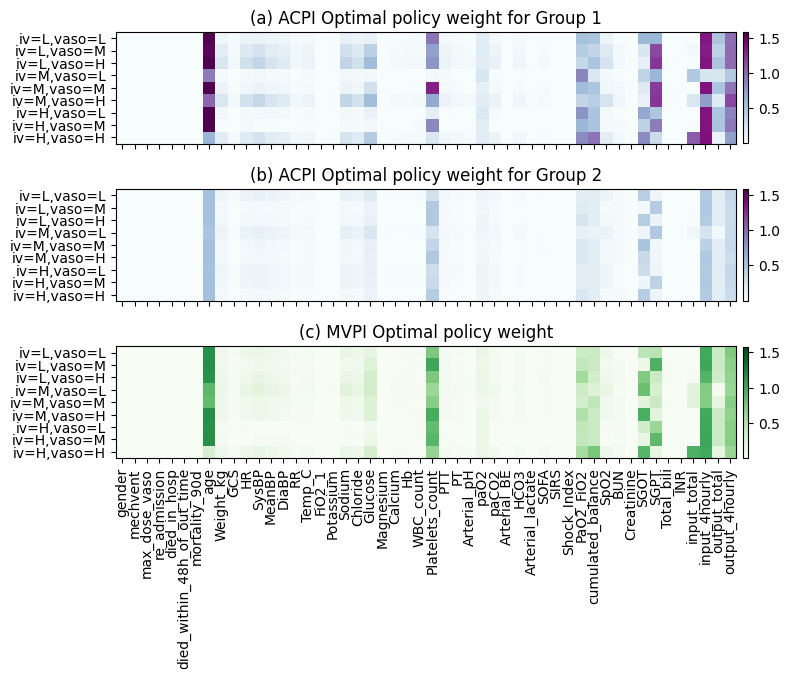

In [48]:
x_lables = FEATURE_COLS
y_labels = [f"iv={al},vaso={vl}" for al in "LMH" for vl in "LMH"]


heatmap_g0 = acl_0.weights().dot(PCA_PROJECTION_MATRIX)
heatmap_g1 = acl_1.weights().dot(PCA_PROJECTION_MATRIX)
heatmap_ng = acl_comb.weights().dot(PCA_PROJECTION_MATRIX)

heatmap_all = np.abs(np.concatenate([heatmap_g0,heatmap_g1, heatmap_ng]))

v_min, v_max = np.min(heatmap_all), np.max(heatmap_all)

fig, axes = plt.subplots(3,figsize=(8,7),sharex=True,layout='tight')

img0 = axes[0].imshow(np.abs(heatmap_g0), cmap="BuPu", vmin=v_min, vmax=v_max)#"Blues")
img1 = axes[1].imshow(np.abs(heatmap_g1), cmap="BuPu", vmin=v_min, vmax=v_max)
img2 = axes[2].imshow(np.abs(heatmap_ng), cmap="Greens", vmin=v_min, vmax=v_max)

axes[0].set_xticks(np.arange(len(x_lables)), labels=x_lables, rotation=90)
axes[0].set_yticks(np.arange(len(y_labels)), labels=y_labels)
axes[1].set_xticks(np.arange(len(x_lables)), labels=x_lables, rotation=90)
axes[1].set_yticks(np.arange(len(y_labels)), labels=y_labels)
axes[2].set_xticks(np.arange(len(x_lables)), labels=x_lables, rotation=90)
axes[2].set_yticks(np.arange(len(y_labels)), labels=y_labels)

axes[0].set_title('(a) ACPI Optimal policy weight for Group 1', loc='center')
axes[1].set_title('(b) ACPI Optimal policy weight for Group 2', loc='center')
axes[2].set_title('(c) MVPI Optimal policy weight', loc='center')


fig.colorbar(img0, ax=axes[0], fraction=0.0088, pad=0.01) 
fig.colorbar(img1, ax=axes[1], fraction=0.0088, pad=0.01)
fig.colorbar(img2, ax=axes[2], fraction=0.0088, pad=0.01)


fig.savefig(f'results/heatmap_optimal_action_{DISCOUNT}.pdf', bbox_inches='tight')

# Done